# Pruebas KSWIN Modificado (configuracion 1 y 2)- Monitorización de datos procedentes de distribuciones cotinuas simuladas


## Importación y carga de librerías


In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import gridspec
from KSWIN_modificado import KSWIN_modificado
import collections
import pandas as pd 
from Lock import excel_lock
from KSWIN_modificado import KSWIN_modificado
from river import drift
import time
from KSWIN_modificado import KSWIN_modificado



## Creación de Datasets para pruebas 


### Abrupto

In [2]:

# ----------------------------------------------------------
# Función para generar un conjunto de datos con 'abrupt drift'
# ----------------------------------------------------------
def crear_dataset_abrupto_General(seed_aux: int = 42, ruido_std: float = 0.1, distribucion: str = "normal"):
    """
    Genera un conjunto de datos sintético que simula un 'abrupt drift' en una distribución.

    Parámetros:
    - seed_aux (int): semilla aleatoria para garantizar reproducibilidad.
    - ruido_std (float): desviación estándar del ruido que se añade a los datos.
    - distribucion (str): tipo de distribución a utilizar ('normal', 'exponential', 'gamma').

    Retorna:
    - data_noisy (np.ndarray): datos generados con ruido y drift incorporado.
    - drifts (dict): diccionario con información sobre la localización del 'abrupt drift'.
    """

    # Diccionario para registrar información de distintos tipos de concept drift
    drifts = {
        "drift_abrupto": [],  # abrupt drift
        "drift_gradual": [],
        "drift_incremental": [],
        "drift_recurrente": []
    }

    # Establecer la semilla para reproducibilidad
    np.random.seed(seed_aux)

    # Número total de muestras y punto exacto donde ocurre el drift
    n_samples = 30000
    drift_point = 15000

    # Parámetros para la distribución antes del drift
    loc1 = np.random.uniform(0, 5)
    scale1 = np.random.uniform(0.5, 1.5)

    # Parámetros para la distribución después del drift
    loc2 = np.random.uniform(0, 5)
    scale2 = np.random.uniform(0.5, 1.5)

    # Generar los datos según la distribución seleccionada
    if distribucion == "normal":
        data_before_drift = np.random.normal(loc=loc1, scale=scale1, size=drift_point)
        data_after_drift = np.random.normal(loc=loc2, scale=scale2, size=n_samples - drift_point)
    elif distribucion == "exponential":
        data_before_drift = np.random.exponential(scale1, drift_point)
        data_after_drift = np.random.exponential(scale2, n_samples - drift_point)
    elif distribucion == "gamma":
        data_before_drift = np.random.gamma(loc1, scale1, drift_point)
        data_after_drift = np.random.gamma(loc2, scale2, n_samples - drift_point)
    else:
        raise ValueError("Error: la distribución especificada no existe.")

    # Unir las dos partes del conjunto de datos
    data = np.concatenate((data_before_drift, data_after_drift))

    # Generar ruido gaussiano
    noise = np.random.normal(loc=0.0, scale=ruido_std, size=n_samples)

    # Añadir el ruido, teniendo en cuenta la distribución
    if distribucion in ["normal", "logistic"]:
        data_noisy = data + noise
    elif distribucion in ["exponential", "gamma"]:
        # Se evitan valores negativos en distribuciones definidas en R+
        data_noisy = np.clip(data + noise, a_min=0, a_max=None)
    else:
        raise ValueError("Error: la distribución especificada no existe.")

    # Registrar el punto donde ocurre el abrupt drift
    drifts["drift_abrupto"].append({"punto": drift_point, "detectado": False})

    return data_noisy, drifts





### Gradual

In [3]:

# ----------------------------------------------------------
# Función sigmoide para controlar la transición gradual
# ----------------------------------------------------------
def sigmoide(x, x0=0, k=1, L=1):
    """
    Función sigmoide estándar para calcular la probabilidad de transición entre dos distribuciones.

    Parámetros:
    - x (np.ndarray): valores de entrada.
    - x0 (float): punto de inflexión de la curva sigmoide.
    - k (float): pendiente de la sigmoide.
    - L (float): valor máximo de la función (por defecto 1).

    Retorna:
    - y (np.ndarray): valores de salida de la función sigmoide.
    """
    y = L / (1 + np.exp(-k * (x - x0)))
    return y

# ----------------------------------------------------------
# Función para generar un conjunto de datos con 'gradual drift'
# ----------------------------------------------------------
def crear_dataset_gradual_General(seed_aux: int = 42, ruido_std: float = 0.1, distribucion: str = "normal"):
    """
    Genera un conjunto de datos sintético que simula un 'gradual drift' mediante una transición sigmoide.

    Parámetros:
    - seed_aux (int): semilla para garantizar reproducibilidad.
    - ruido_std (float): desviación estándar del ruido añadido.
    - distribucion (str): tipo de distribución ('normal', 'exponential', 'gamma').

    Retorna:
    - data_noisy (np.ndarray): datos con ruido y drift gradual incorporado.
    - drifts (dict): información sobre el intervalo donde ocurre el 'gradual drift'.
    """

    drifts = {
        "drift_abrupto": [],
        "drift_gradual": [],
        "drift_incremental": [],
        "drift_recurrente": []
    }

    # Establecer semilla para reproducibilidad
    np.random.seed(seed_aux)

    # Número total de muestras y punto donde comienza el drift
    n_samples = 30000
    drift_point = 15000

    # Parámetros de la distribución antes del drift
    loc1 = np.random.uniform(0, 5)
    scale1 = np.random.uniform(0.5, 1.5)

    # Parámetros de la distribución después del drift
    loc2 = np.random.uniform(0, 5)
    scale2 = np.random.uniform(0.5, 1.5)

    # Longitud de la transición gradual (aleatoria)
    tamanho = np.random.choice([1000, 2000, 3000])

    # Generar datos antes y después de la transición, según la distribución
    if distribucion == "normal":
        data_before_drift = np.random.normal(loc=loc1, scale=scale1, size=drift_point)
        data_after_drift = np.random.normal(loc=loc2, scale=scale2, size=n_samples - drift_point - tamanho)
    elif distribucion == "exponential":
        data_before_drift = np.random.exponential(scale1, drift_point)
        data_after_drift = np.random.exponential(scale2, n_samples - drift_point - tamanho)
    elif distribucion == "gamma":
        data_before_drift = np.random.gamma(loc1, scale1, drift_point)
        data_after_drift = np.random.gamma(loc2, scale2, n_samples - drift_point - tamanho)
    else:
        raise ValueError("Error: la distribución especificada no existe")

    # Crear probabilidades de transición con una función sigmoide
    x = np.arange(tamanho)
    y = sigmoide(x, x0=tamanho/2, k=8/tamanho, L=1)

    # Generar los datos de transición usando una mezcla probabilística controlada
    data_transition = np.zeros(tamanho)
    for i in range(tamanho):
        # Selección estocástica de distribución basada en la sigmoide
        random_choices = np.random.choice([0, 1], size=1, p=[1 - y[i], y[i]])
        if random_choices == 0:
            data_transition[i] = np.random.normal(loc=loc1, scale=scale1, size=1)[0]
        else:
            data_transition[i] = np.random.normal(loc=loc2, scale=scale2, size=1)[0]

    # Concatenar las tres partes: antes del drift, transición, y después del drift
    data = np.concatenate((data_before_drift, data_transition, data_after_drift))

    # Generar y añadir ruido gaussiano
    noise = np.random.normal(loc=0.0, scale=ruido_std, size=n_samples)

    if distribucion in ["normal", "logistic"]:
        data_noisy = data + noise
    elif distribucion in ["exponential", "gamma"]:
        data_noisy = np.clip(data + noise, a_min=0, a_max=None)
    else:
        raise ValueError("Error: la distribución especificada no existe")

    # Registrar el intervalo del gradual drift (como incremental en este caso)
    drifts["drift_incremental"].append({
        "inicio": drift_point,
        "fin": drift_point + tamanho,
        "detectado": False
    })

    return data_noisy, drifts


### Incremental



In [4]:
# ----------------------------------------------------------
# Función para generar un conjunto de datos con 'incremental drift'
# ----------------------------------------------------------

def crear_dataset_incremental_General(seed_aux: int = 42, ruido_std: float = 0.1, distribucion: str = "normal"):
    """
    Genera un conjunto de datos sintético que simula un 'incremental drift' mediante interpolación lineal
    de los parámetros de la distribución.

    Parámetros:
    - seed_aux (int): semilla para garantizar reproducibilidad.
    - ruido_std (float): desviación estándar del ruido añadido.
    - distribucion (str): tipo de distribución ('normal', 'exponential', 'gamma').

    Retorna:
    - data_noisy (np.ndarray): datos con ruido y 'incremental drift' incorporado.
    - drifts (dict): información sobre el intervalo donde ocurre el drift.
    """

    drifts = {
        "drift_abrupto": [],
        "drift_gradual": [],
        "drift_incremental": [],
        "drift_recurrente": []
    }

    # Semilla para reproducibilidad
    np.random.seed(seed_aux)

    # Número total de muestras y punto inicial del drift
    n_samples = 30000
    drift_point = 15000

    # Parámetros iniciales y finales de la distribución
    loc1 = np.random.uniform(0, 5)
    scale1 = np.random.uniform(0.5, 1.5)

    loc2 = np.random.uniform(0, 5)
    scale2 = np.random.uniform(0.5, 1.5)

    # Longitud del intervalo de transición (incremental)
    tamanho = np.random.choice([1000, 2000, 3000])

    # Generar los datos antes y después del drift
    if distribucion == "normal":
        data_before_drift = np.random.normal(loc=loc1, scale=scale1, size=drift_point)
        data_after_drift = np.random.normal(loc=loc2, scale=scale2, size=n_samples - drift_point - tamanho)
    elif distribucion == "exponential":
        data_before_drift = np.random.exponential(scale1, drift_point)
        data_after_drift = np.random.exponential(scale2, n_samples - drift_point - tamanho)
    elif distribucion == "gamma":
        data_before_drift = np.random.gamma(loc1, scale1, drift_point)
        data_after_drift = np.random.gamma(loc2, scale2, n_samples - drift_point - tamanho)
    else:
        raise ValueError("Error: la distribución especificada no existe")

    # Interpolación lineal de parámetros para transición incremental
    alpha = np.linspace(0, 1, num=tamanho)
    transition_mean = (1 - alpha) * loc1 + alpha * loc2
    transition_std = (1 - alpha) * scale1 + alpha * scale2

    # Generar datos de transición con parámetros interpolados
    data_transition = np.random.normal(loc=transition_mean, scale=transition_std)

    # Concatenar los tres segmentos: antes, transición, después
    data = np.concatenate((data_before_drift, data_transition, data_after_drift))

    # Generar ruido gaussiano
    noise = np.random.normal(loc=0.0, scale=ruido_std, size=n_samples)

    # Añadir ruido según tipo de distribución
    if distribucion in ["normal", "logistic"]:
        data_noisy = data + noise
    elif distribucion in ["exponential", "gamma"]:
        data_noisy = np.clip(data + noise, a_min=0, a_max=None)
    else:
        raise ValueError("Error: la distribución especificada no existe")

    # Registrar el intervalo del incremental drift
    drifts["drift_incremental"].append({
        "inicio": drift_point,
        "fin": drift_point + tamanho,
        "detectado": False
    })

    return data_noisy, drifts


## Funciones utilizadas en la experimentación


### Función para graficar 

In [ ]:

# ----------------------------------------------------------
# Función para visualizar un conjunto de datos con 'concept drift'
# ----------------------------------------------------------
def plot_data(dataset, drift_detectados, drifts):
    """
    Visualiza el conjunto de datos con sus valores y líneas verticales indicando
    los puntos o intervalos de distintos tipos de 'concept drift'.

    Parámetros:
    - dataset (np.ndarray): conjunto de datos a visualizar.
    - drift_detectados (list[int] o None): lista de índices donde se detectó drift
      mediante algún método automático (se marcan en rojo).
    - drifts (dict): diccionario que contiene información de los drift reales generados
      por tipo: 'drift_abrupto', 'drift_gradual', 'drift_incremental', 'drift_recurrente'.

    Tipos de líneas:
    - 'Drift Detectado': línea roja discontinua (predicciones o detecciones).
    - 'Drift Abrupto': línea azul discontinua en la posición del cambio.
    - 'Drift Gradual': dos líneas verdes delimitando el intervalo de transición.
    - 'Drift Incremental': dos líneas marrones delimitando el cambio progresivo.
    - 'Drift Recurrente': dos líneas amarillas marcando repeticiones cíclicas.

    Retorna:
    - No retorna ningún valor. La función muestra una figura matplotlib.
    """
    fig = plt.figure(figsize=(12, 6))
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
    
    ax0 = plt.subplot(gs[0])
    ax0.set_title('Dataset')
    ax0.plot(dataset, 'o', label='Datos')
    ax0.set_ylabel('Valor')
    
    legend_labels = []
    
    # Detecciones automáticas (si existen)
    if drift_detectados is not None:
        for punto in drift_detectados:
            ax0.axvline(x=punto, color='r', linestyle='--',
                        label='Drift Detectado' if 'Drift Detectado' not in legend_labels else '')
        legend_labels.append('Drift Detectado')
    
    # Visualizar cada tipo de drift simulado
    for punto in drifts.get("drift_abrupto", []):
        ax0.axvline(x=punto.get("punto"), color='b', linestyle='--',
                    label='Drift Abrupto' if 'Drift Abrupto' not in legend_labels else '')
        legend_labels.append('Drift Abrupto')
    
    for punto in drifts.get("drift_gradual", []):
        ax0.axvline(x=punto.get("inicio"), color='g', linestyle='--',
                    label='Drift Gradual' if 'Drift Gradual' not in legend_labels else '')
        ax0.axvline(x=punto.get("fin"), color='g', linestyle='--')
        legend_labels.append('Drift Gradual')
    
    for punto in drifts.get("drift_incremental", []):
        ax0.axvline(x=punto.get("inicio"), color='brown', linestyle='--',
                    label='Drift Incremental' if 'Drift Incremental' not in legend_labels else '')
        ax0.axvline(x=punto.get("fin"), color='brown', linestyle='--')
        legend_labels.append('Drift Incremental')
    
    for punto in drifts.get("drift_recurrente", []):
        ax0.axvline(x=punto.get("inicio"), color='y', linestyle='--',
                    label='Drift Recurrente' if 'Drift Recurrente' not in legend_labels else '')
        ax0.axvline(x=punto.get("fin"), color='y', linestyle='--')
        legend_labels.append('Drift Recurrente')
    
    ax0.legend()
    plt.show()


### Detección de drift

In [ ]:


# ----------------------------------------------------------
# Función para realizar la detección de 'concept drift' sobre un dataset
# ----------------------------------------------------------
def realizar_deteccion(dataset, drifts, detector, longitud_batch, falsas_alarmas, imprimir_mensajes: bool = True):
    """
    Ejecuta un detector de 'concept drift' sobre un conjunto de datos y compara las detecciones
    con los puntos de drift reales para identificar aciertos y falsas alarmas.

    Parámetros:
    - dataset (np.ndarray): conjunto de datos sobre el que se aplicará la detección.
    - drifts (dict): diccionario con los drifts reales generados por tipo (abrupt, gradual, incremental, recurrente).
    - detector (objeto): instancia de un detector compatible con .update() y .drift_detected.
    - longitud_batch (int): tamaño de la ventana para alimentar al detector.
    - falsas_alarmas (list): lista externa que se irá completando con los índices de falsas alarmas.
    - imprimir_mensajes (bool): si True, se imprime por pantalla cada detección realizada.

    Retorna:
    - tuple:
        - puntos_detectados (list): índices donde se detectó un drift real.
        - falsas_alarmas (list): índices de falsas alarmas (detecciones fuera de ventanas esperadas).
    """

    # Selección del buffer adecuado según el tipo de detector
    if isinstance(detector, KSWIN_modificado):
        batch_detector = collections.deque(maxlen=longitud_batch)
    else:
        batch_detector = collections.deque(maxlen=1)

    puntos_detectados = []

    for i, val in enumerate(dataset):
        # Reinicio del contador si se está en un punto de inicio o fin de algún drift
        for punto in drifts["drift_abrupto"]:
            if punto.get("punto") in [i, i + 2000]:
                iteracciones = 0
                break
        for punto in drifts["drift_gradual"]:
            if i in [punto.get("inicio"), punto.get("fin")]:
                iteracciones = 0
                break
        for punto in drifts["drift_incremental"]:
            if i in [punto.get("inicio"), punto.get("fin")]:
                iteracciones = 0
                break
        for punto in drifts["drift_recurrente"]:
            if i in [punto.get("inicio"), punto.get("fin")]:
                iteracciones = 0
                break

        # Alimentar el detector
        batch_detector.append(val)

        if len(batch_detector) == batch_detector.maxlen:
            if isinstance(detector, KSWIN_modificado):
                detector.update(batch_detector)
            else:
                detector.update(val)

            batch_detector.clear()

            # Si el detector ha identificado drift
            if detector.drift_detected:
                if imprimir_mensajes:
                    print(f'Drift detectado en el índice {i}')

                flag = True  # Marca para indicar si es falsa alarma

                # Verificar si el punto está dentro de alguna ventana de drift real
                for punto in drifts["drift_abrupto"]:
                    if i < punto.get("punto"):
                        punto["detectado"] = True
                    if punto.get("punto") < i < punto.get("punto") + 2000:
                        punto["detectado"] = True
                        flag = False
                        break

                for punto in drifts["drift_gradual"]:
                    if i < punto.get("inicio"):
                        punto["detectado"] = True
                    if punto.get("inicio") < i < punto.get("fin"):
                        punto["detectado"] = True
                        flag = False
                        break

                for punto in drifts["drift_incremental"]:
                    if i < punto.get("inicio"):
                        punto["detectado"] = True
                    if punto.get("inicio") < i < punto.get("fin"):
                        punto["detectado"] = True
                        flag = False
                        break

                for punto in drifts["drift_recurrente"]:
                    if i < punto.get("inicio"):
                        punto["detectado"] = True
                    if punto.get("inicio") < i < punto.get("fin"):
                        punto["detectado"] = True
                        flag = False
                        break

                # Clasificar como falsa alarma o detección válida
                if flag:
                    falsas_alarmas.append(i)
                else:
                    puntos_detectados.append(i)

                break  # Salir tras la primera detección para no seguir escaneando

    return (puntos_detectados, falsas_alarmas)

                
                
                
    

### Cálculo de métricas y estadísticas. Escritura de archivo con resultados.

In [ ]:

# ----------------------------------------------------------
# Función para guardar estadísticas de rendimiento de detección de 'concept drift'
# ----------------------------------------------------------
def guardar_estadisticas(detector, tipo_drift, distribucion, drifts, puntos_detectados, falsas_alarmas, tiempo_ejecucion, nombre_archivo):
    """
    Calcula y guarda las métricas de evaluación de la detección de 'concept drift' en un archivo Excel.

    Métricas calculadas:
    - FDR (False Discovery Rate): proporción de falsas alarmas sobre el total de detecciones (FP / (FP + TP)).
    - MDR (Missed Detection Rate): proporción de drifts no detectados (FN / (FN + TP)).
    - Tiempo de ejecución.

    Parámetros:
    - detector (str): nombre del detector utilizado (será el nombre de la hoja Excel).
    - tipo_drift (str): tipo de drift simulado (e.g. 'abrupt', 'gradual').
    - distribucion (str): tipo de distribución utilizada ('normal', 'gamma', etc.).
    - drifts (dict): estructura que contiene los drifts simulados y si fueron detectados.
    - puntos_detectados (list[int]): índices donde se detectó correctamente un drift.
    - falsas_alarmas (list[int]): índices de detecciones falsas (no pertenecen a zonas con drift).
    - tiempo_ejecucion (float): duración del experimento en segundos.
    - nombre_archivo (str): ruta al archivo Excel donde se guardarán las métricas.

    Retorna:
    - No retorna nada. Escribe los resultados en un archivo Excel.
    """

    print(f"Número de falsas alarmas: {len(falsas_alarmas)}")

    # Cálculo de FDR (False Discovery Rate): FP / (FP + TP)
    totales = len(puntos_detectados) + len(falsas_alarmas)
    if totales != 0:
        FDR = round(len(falsas_alarmas) / totales, 5)
        print(f"FDR: {FDR}")
    else:
        FDR = None

    # Cálculo de MDR (Missed Detection Rate): FN / (FN + TP)
    FN = 0  # Falsos negativos: drifts reales no detectados
    TP = 0  # Verdaderos positivos: drifts reales correctamente detectados
    for drift in drifts:
        for dr in drift:
            for punto in drift[dr]:
                if not punto["detectado"]:
                    print(f"Drift {dr} en el punto {punto} no detectado")
                    FN += 1
                else:
                    TP += 1

    MDR = round(FN / (FN + TP), 5) if (FN + TP) > 0 else None
    print(f"MDR: {MDR}")
    print(f"Tiempo de ejecución: {tiempo_ejecucion:.3f} segundos")

    # Crear DataFrame con los resultados
    df = pd.DataFrame([{
        "tipo_drift": tipo_drift,
        "distribucion": distribucion,
        "FDR": FDR,
        "MDR": MDR,
        "tiempo_ejecucion": tiempo_ejecucion
    }])

    # Guardar en archivo Excel, actualizando hoja del detector si ya existe
    with excel_lock:
        try:
            with pd.ExcelFile(nombre_archivo) as xls:
                if detector in xls.sheet_names:
                    df_aux = pd.read_excel(xls, sheet_name=detector)
                    matching_rows = df_aux[
                        (df_aux["tipo_drift"] == df["tipo_drift"].iloc[0]) &
                        (df_aux["distribucion"] == df["distribucion"].iloc[0])
                    ]
                    if not matching_rows.empty:
                        index_existente = matching_rows.index[0]
                        df_aux.iloc[index_existente] = df.iloc[0]
                    else:
                        df_aux = pd.concat([df_aux, df], ignore_index=True)

                    with pd.ExcelWriter(nombre_archivo, engine='openpyxl', mode='a') as writer:
                        writer.book.remove(writer.book[detector])
                        df_aux.to_excel(writer, sheet_name=detector, index=False)
                else:
                    with pd.ExcelWriter(nombre_archivo, engine='openpyxl', mode='a') as writer:
                        df.to_excel(writer, sheet_name=detector, index=False)

        except FileNotFoundError:
            with pd.ExcelWriter(nombre_archivo, engine='openpyxl') as writer:
                df.to_excel(writer, sheet_name=detector, index=False)

        except Exception as e:
            print(f"Error general: {e}")



## KSWIN configuración original

### Abrupt drift

#### Distribución normal


Drift detectado en el índice 15062


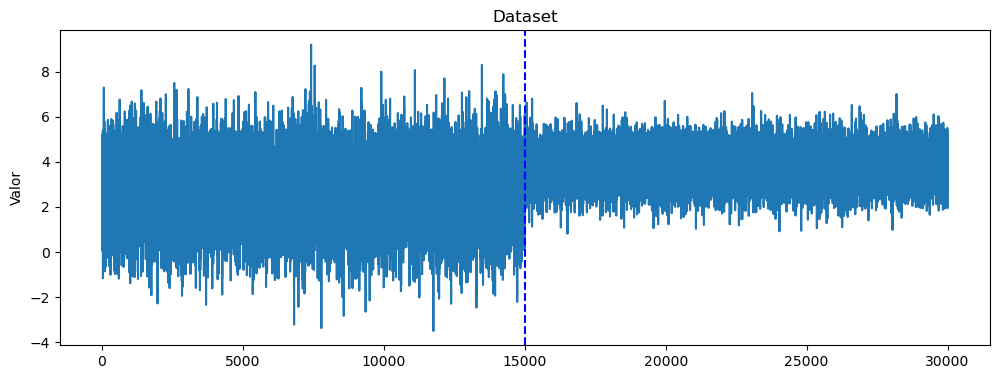

In [ ]:


num_iteracciones = 1000

puntos_detectados = []
falsas_alarmas = []
drifts_totales = []
tiempo_total = 0

for i in range(num_iteracciones): 

    kswin = drift.KSWIN(alpha=0.0001, window_size=3000, stat_size=300,seed=42)
 
    data_noisy, drifts = crear_dataset_abrupto_General(seed_aux=23 + i, ruido_std=0.1, distribucion="normal")

    drifts_totales.append(drifts)


    tiempo_inicial = time.time()

    puntos_detectados_aux, falsas_alarmas_aux = realizar_deteccion(data_noisy, drifts,  kswin, 300, [], True)


    tiempo_total += time.time() - tiempo_inicial

    # plot_data(data_noisy, None , drifts)


    puntos_detectados.extend(puntos_detectados_aux)
    falsas_alarmas.extend(falsas_alarmas_aux)




In [ ]:
guardar_estadisticas("KSWIN", "abrupto", "normal",drifts_totales, puntos_detectados, falsas_alarmas, tiempo_total, "estadisticas_pruebas_generales.xlsx")

#### Distribución exponencial

In [ ]:

num_iteracciones = 1000

puntos_detectados = []
falsas_alarmas = []
drifts_totales = []

tiempo_total = 0

for i in range(num_iteracciones): 

    kswin = drift.KSWIN(alpha=0.0001, window_size=3000, stat_size=300,seed=42)
 
    data_noisy, drifts = crear_dataset_abrupto_General(seed_aux=23 + i, ruido_std=0.1, distribucion="exponential")

    drifts_totales.append(drifts)

    # plot_data(data_noisy, None, drifts)

    tiempo_inicial = time.time()

    puntos_detectados_aux, falsas_alarmas_aux = realizar_deteccion(data_noisy, drifts,  kswin, 100, [], True)

    tiempo_total += time.time() - tiempo_inicial

    puntos_detectados.extend(puntos_detectados_aux)
    falsas_alarmas.extend(falsas_alarmas_aux)


Drift detectado en el índice 15092


In [55]:
guardar_estadisticas("KSWIN", "abrupto", "exponencial",drifts_totales, puntos_detectados, falsas_alarmas, tiempo_total, "estadisticas_pruebas_generales.xlsx")

Numero de falsas alarmas 0
FAR: 0.0
MDR: 0.0
Tiempo de ejecucion: 13.20808744430542


#### Distribucion gamma


In [ ]:

num_iteracciones = 1000

puntos_detectados = []
falsas_alarmas = []
drifts_totales = []

tiempo_total = 0

for i in range(num_iteracciones): 

    kswin = drift.KSWIN(alpha=0.0001, window_size=3000, stat_size=300,seed=42)
 
    data_noisy, drifts = crear_dataset_abrupto_General(seed_aux=23 + i, ruido_std=0.1, distribucion="gamma")

    drifts_totales.append(drifts)

    # plot_data(data_noisy, None, drifts)

    tiempo_inicial = time.time()

    puntos_detectados_aux, falsas_alarmas_aux = realizar_deteccion(data_noisy, drifts,  kswin, 100, [], True)

    tiempo_total += time.time() - tiempo_inicial

    puntos_detectados.extend(puntos_detectados_aux)
    falsas_alarmas.extend(falsas_alarmas_aux)

Drift detectado en el índice 15180


In [60]:
guardar_estadisticas("KSWIN", "abrupto", "gamma",drifts_totales, puntos_detectados, falsas_alarmas, tiempo_total, "estadisticas_pruebas_generales.xlsx")

Numero de falsas alarmas 0
FAR: 0.0
MDR: 0.0
Tiempo de ejecucion: 13.493180751800537


### Incremental drift

#### Distribucion normal

In [ ]:


num_iteracciones = 1000

puntos_detectados = []
falsas_alarmas = []
drifts_totales = []

tiempo_total = 0

for i in range(num_iteracciones): 

    kswin = drift.KSWIN(alpha=0.0001, window_size=3000, stat_size=300,seed=42)
 
    data_noisy, drifts = crear_dataset_incremental_General(seed_aux=24 + i, ruido_std=0.1, distribucion="normal")

    drifts_totales.append(drifts)

    # plot_data(data_noisy, None, drifts)

    tiempo_inicial = time.time()

    puntos_detectados_aux, falsas_alarmas_aux = realizar_deteccion(data_noisy, drifts,  kswin, 100, [], True)

    tiempo_total += time.time() - tiempo_inicial

    puntos_detectados.extend(puntos_detectados_aux)
    falsas_alarmas.extend(falsas_alarmas_aux)

Drift detectado en el índice 9617
Drift detectado en el índice 15234
Drift detectado en el índice 9497
Drift detectado en el índice 12274
Drift detectado en el índice 15301
Drift detectado en el índice 15343
Drift detectado en el índice 16373
Drift detectado en el índice 15234
Drift detectado en el índice 5905
Drift detectado en el índice 16317
Drift detectado en el índice 17000
Drift detectado en el índice 4442
Drift detectado en el índice 14528
Drift detectado en el índice 15290
Drift detectado en el índice 10374
Drift detectado en el índice 7444
Drift detectado en el índice 8880
Drift detectado en el índice 4826
Drift detectado en el índice 3224
Drift detectado en el índice 17180
Drift detectado en el índice 12691
Drift detectado en el índice 15190
Drift detectado en el índice 15371
Drift detectado en el índice 15271
Drift detectado en el índice 13890
Drift detectado en el índice 15264
Drift detectado en el índice 3592
Drift detectado en el índice 14949
Drift detectado en el índice 

In [ ]:
guardar_estadisticas("KSWIN", "incremental", "normal",drifts_totales, puntos_detectados, falsas_alarmas, tiempo_total, "estadisticas_pruebas_generales.xlsx")

Numero de falsas alarmas 518
FAR: 0.5227
Drift drift_incremental en el punto {'inicio': 15000, 'fin': 17000, 'detectado': False} no detectado
Drift drift_incremental en el punto {'inicio': 15000, 'fin': 17000, 'detectado': False} no detectado
Drift drift_incremental en el punto {'inicio': 15000, 'fin': 17000, 'detectado': False} no detectado
Drift drift_incremental en el punto {'inicio': 15000, 'fin': 18000, 'detectado': False} no detectado
Drift drift_incremental en el punto {'inicio': 15000, 'fin': 17000, 'detectado': False} no detectado
Drift drift_incremental en el punto {'inicio': 15000, 'fin': 18000, 'detectado': False} no detectado
Drift drift_incremental en el punto {'inicio': 15000, 'fin': 16000, 'detectado': False} no detectado
Drift drift_incremental en el punto {'inicio': 15000, 'fin': 17000, 'detectado': False} no detectado
Drift drift_incremental en el punto {'inicio': 15000, 'fin': 16000, 'detectado': False} no detectado
Drift drift_incremental en el punto {'inicio': 150

#### Distribucion exponencial

In [ ]:

num_iteracciones = 1000

puntos_detectados = []
falsas_alarmas = []
drifts_totales = []

tiempo_total = 0

for i in range(num_iteracciones): 

    kswin = drift.KSWIN(alpha=0.0001, window_size=3000, stat_size=300,seed=42)
 
    data_noisy, drifts = crear_dataset_incremental_General(seed_aux=24 + i, ruido_std=0.1, distribucion="exponential")

    drifts_totales.append(drifts)

    # plot_data(data_noisy, None, drifts)

    tiempo_inicial = time.time()

    puntos_detectados_aux, falsas_alarmas_aux = realizar_deteccion(data_noisy, drifts,  kswin, 100, [], True)

    tiempo_total += time.time() - tiempo_inicial

    puntos_detectados.extend(puntos_detectados_aux)
    falsas_alarmas.extend(falsas_alarmas_aux)

Drift detectado en el índice 9290


In [19]:
guardar_estadisticas("KSWIN", "incremental", "exponencial",drifts_totales, puntos_detectados, falsas_alarmas, tiempo_total, "estadisticas_pruebas_generales.xlsx")

Numero de falsas alarmas 1
FAR: 1.0
MDR: 0.0
Tiempo de ejecucion: 7.368058919906616


#### Distribucion gamma


In [ ]:

num_iteracciones = 1000

puntos_detectados = []
falsas_alarmas = []
drifts_totales = []

tiempo_total = 0

for i in range(num_iteracciones): 

    kswin = drift.KSWIN(alpha=0.0001, window_size=3000, stat_size=300,seed=42)
 
    data_noisy, drifts = crear_dataset_incremental_General(seed_aux=24 + i, ruido_std=0.1, distribucion="gamma")

    drifts_totales.append(drifts)

    # plot_data(data_noisy, None, drifts)

    tiempo_inicial = time.time()

    puntos_detectados_aux, falsas_alarmas_aux = realizar_deteccion(data_noisy, drifts,  kswin, 100, [], True)

    tiempo_total += time.time() - tiempo_inicial

    puntos_detectados.extend(puntos_detectados_aux)
    falsas_alarmas.extend(falsas_alarmas_aux)

Drift detectado en el índice 15087


In [21]:
guardar_estadisticas("KSWIN", "incremental", "gamma",drifts_totales, puntos_detectados, falsas_alarmas, tiempo_total, "estadisticas_pruebas_generales.xlsx")

Numero de falsas alarmas 0
FAR: 0.0
MDR: 0.0
Tiempo de ejecucion: 13.364972591400146


### Gradual drift

#### Distribucion normal

In [ ]:

num_iteracciones = 1000

puntos_detectados = []
falsas_alarmas = []
drifts_totales = []

tiempo_total = 0

for i in range(num_iteracciones): 

    kswin = drift.KSWIN(alpha=0.0001, window_size=3000, stat_size=300,seed=42)
 
    data_noisy, drifts = crear_dataset_gradual_General(seed_aux=25 + i, ruido_std=0.1, distribucion="normal")

    drifts_totales.append(drifts)

    # plot_data(data_noisy, None, drifts)

    tiempo_inicial = time.time()

    puntos_detectados_aux, falsas_alarmas_aux = realizar_deteccion(data_noisy, drifts,  kswin, 100, [], True)

    tiempo_total += time.time() - tiempo_inicial

    puntos_detectados.extend(puntos_detectados_aux)
    falsas_alarmas.extend(falsas_alarmas_aux)

Drift detectado en el índice 15394
Drift detectado en el índice 9497
Drift detectado en el índice 6974
Drift detectado en el índice 15445
Drift detectado en el índice 15561
Drift detectado en el índice 17086
Drift detectado en el índice 4819
Drift detectado en el índice 15432
Drift detectado en el índice 15951
Drift detectado en el índice 16636
Drift detectado en el índice 4442
Drift detectado en el índice 11773
Drift detectado en el índice 16178
Drift detectado en el índice 10374
Drift detectado en el índice 15446
Drift detectado en el índice 8897
Drift detectado en el índice 15352
Drift detectado en el índice 16081
Drift detectado en el índice 16398
Drift detectado en el índice 12691
Drift detectado en el índice 15411
Drift detectado en el índice 3634
Drift detectado en el índice 12105
Drift detectado en el índice 13890
Drift detectado en el índice 15839
Drift detectado en el índice 3592
Drift detectado en el índice 3144
Drift detectado en el índice 15379
Drift detectado en el índice

In [ ]:
guardar_estadisticas("KSWIN", "gradual", "normal",drifts_totales, puntos_detectados, falsas_alarmas, tiempo_total, "estadisticas_pruebas_generales.xlsx")

Numero de falsas alarmas 501
FAR: 0.50402
Drift drift_incremental en el punto {'inicio': 15000, 'fin': 17000, 'detectado': False} no detectado
Drift drift_incremental en el punto {'inicio': 15000, 'fin': 17000, 'detectado': False} no detectado
Drift drift_incremental en el punto {'inicio': 15000, 'fin': 17000, 'detectado': False} no detectado
Drift drift_incremental en el punto {'inicio': 15000, 'fin': 17000, 'detectado': False} no detectado
Drift drift_incremental en el punto {'inicio': 15000, 'fin': 17000, 'detectado': False} no detectado
Drift drift_incremental en el punto {'inicio': 15000, 'fin': 17000, 'detectado': False} no detectado
Drift drift_incremental en el punto {'inicio': 15000, 'fin': 16000, 'detectado': False} no detectado
Drift drift_incremental en el punto {'inicio': 15000, 'fin': 18000, 'detectado': False} no detectado
Drift drift_incremental en el punto {'inicio': 15000, 'fin': 16000, 'detectado': False} no detectado
Drift drift_incremental en el punto {'inicio': 15

#### Distribucion exponencial

In [ ]:

num_iteracciones = 1000

puntos_detectados = []
falsas_alarmas = []
drifts_totales = []

tiempo_total = 0

for i in range(num_iteracciones): 

    kswin = drift.KSWIN(alpha=0.0001, window_size=3000, stat_size=300,seed=42)
 
    data_noisy, drifts = crear_dataset_gradual_General(seed_aux=25 + i, ruido_std=0.1, distribucion="exponential")

    drifts_totales.append(drifts)

    # plot_data(data_noisy, None, drifts)

    tiempo_inicial = time.time()

    puntos_detectados_aux, falsas_alarmas_aux = realizar_deteccion(data_noisy, drifts,  kswin, 100, [], True)

    tiempo_total += time.time() - tiempo_inicial

    puntos_detectados.extend(puntos_detectados_aux)
    falsas_alarmas.extend(falsas_alarmas_aux)

Drift detectado en el índice 15034


In [23]:
guardar_estadisticas("KSWIN", "gradual", "exponencial",drifts_totales, puntos_detectados, falsas_alarmas, tiempo_total, "estadisticas_pruebas_generales.xlsx")

Numero de falsas alarmas 0
FAR: 0.0
MDR: 0.0
Tiempo de ejecucion: 15.252921342849731


#### Distribucion gamma

In [ ]:

num_iteracciones = 1000

puntos_detectados = []
falsas_alarmas = []
drifts_totales = []

tiempo_total = 0

for i in range(num_iteracciones): 

    kswin = drift.KSWIN(alpha=0.0001, window_size=3000, stat_size=300,seed=42)
 
    data_noisy, drifts = crear_dataset_gradual_General(seed_aux=25 + i, ruido_std=0.1, distribucion="gamma")

    drifts_totales.append(drifts)

    # plot_data(data_noisy, None, drifts)

    tiempo_inicial = time.time()

    puntos_detectados_aux, falsas_alarmas_aux = realizar_deteccion(data_noisy, drifts,  kswin, 100, [], True)

    tiempo_total += time.time() - tiempo_inicial

    puntos_detectados.extend(puntos_detectados_aux)
    falsas_alarmas.extend(falsas_alarmas_aux)

Drift detectado en el índice 15179


In [25]:
guardar_estadisticas("KSWIN", "gradual", "gamma",drifts_totales, puntos_detectados, falsas_alarmas, tiempo_total, "estadisticas_pruebas_generales.xlsx")

Numero de falsas alarmas 0
FAR: 0.0
MDR: 0.0
Tiempo de ejecucion: 14.975170612335205


## KSWIN Modificado (Configuración 1 y 2)

### Abrupt drift

#### Distribucion normal (configuracion 2)

Drift detectado en el índice 15299


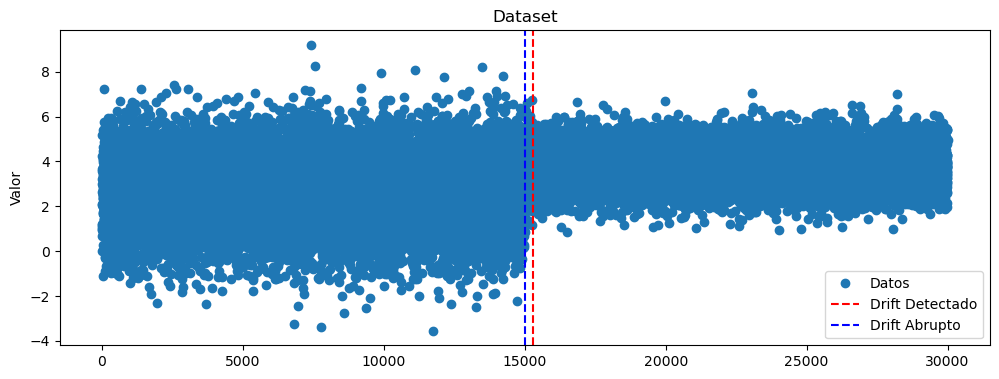

In [ ]:


num_iteracciones = 1000

puntos_detectados = []
falsas_alarmas = []
drifts_totales = []
tiempo_total = 0

for i in range(num_iteracciones): 
    
    kswin_modificado = KSWIN_modificado(alpha=0.001, window_start=0, window_size=3000, stat_size=300, confirm_drift=False, alternative='two-sided', configuracion=2, es_continua=True)
    data_noisy, drifts = crear_dataset_abrupto_General(seed_aux=23 + i, ruido_std=0.05, distribucion="normal")

    drifts_totales.append(drifts)

    tiempo_inicial = time.time()

    puntos_detectados_aux, falsas_alarmas_aux = realizar_deteccion(data_noisy, drifts,  kswin_modificado, 300, [], True)

    tiempo_total += time.time() - tiempo_inicial

    # plot_data(data_noisy, puntos_detectados_aux, drifts)


    puntos_detectados.extend(puntos_detectados_aux)
    falsas_alarmas.extend(falsas_alarmas_aux)

In [ ]:
guardar_estadisticas("KSWIN_modificado", "abrupto", "normal",drifts_totales, puntos_detectados, falsas_alarmas, tiempo_total, "estadisticas_pruebas_generales.xlsx")

Numero de falsas alarmas 14
FAR: 0.01449
Drift drift_abrupto en el punto {'punto': 15000, 'detectado': False} no detectado
Drift drift_abrupto en el punto {'punto': 15000, 'detectado': False} no detectado
Drift drift_abrupto en el punto {'punto': 15000, 'detectado': False} no detectado
Drift drift_abrupto en el punto {'punto': 15000, 'detectado': False} no detectado
Drift drift_abrupto en el punto {'punto': 15000, 'detectado': False} no detectado
Drift drift_abrupto en el punto {'punto': 15000, 'detectado': False} no detectado
Drift drift_abrupto en el punto {'punto': 15000, 'detectado': False} no detectado
Drift drift_abrupto en el punto {'punto': 15000, 'detectado': False} no detectado
Drift drift_abrupto en el punto {'punto': 15000, 'detectado': False} no detectado
Drift drift_abrupto en el punto {'punto': 15000, 'detectado': False} no detectado
Drift drift_abrupto en el punto {'punto': 15000, 'detectado': False} no detectado
Drift drift_abrupto en el punto {'punto': 15000, 'detecta

#### Distribucion normal (configuracion 1)

In [ ]:


num_iteracciones = 1000

puntos_detectados = []
falsas_alarmas = []
drifts_totales = []
tiempo_total = 0

for i in range(num_iteracciones): 
    
    kswin_modificado = KSWIN_modificado(alpha=0.001, window_start=0, window_size=3000, stat_size=300, confirm_drift=False, alternative='two-sided', configuracion=1, es_continua=True)
    data_noisy, drifts = crear_dataset_abrupto_General(seed_aux=23 + i, ruido_std=0.05, distribucion="normal")

    drifts_totales.append(drifts)

    # plot_data(data_noisy, None, drifts)

    tiempo_inicial = time.time()

    puntos_detectados_aux, falsas_alarmas_aux = realizar_deteccion(data_noisy, drifts,  kswin_modificado, 300, [], True)

    tiempo_total += time.time() - tiempo_inicial

    puntos_detectados.extend(puntos_detectados_aux)
    falsas_alarmas.extend(falsas_alarmas_aux)

Drift detectado en el índice 15299
Drift detectado en el índice 15299
Drift detectado en el índice 15299
Drift detectado en el índice 15299
Drift detectado en el índice 15299
Drift detectado en el índice 15299
Drift detectado en el índice 15299
Drift detectado en el índice 15299
Drift detectado en el índice 15299
Drift detectado en el índice 15299
Drift detectado en el índice 15599
Drift detectado en el índice 15299
Drift detectado en el índice 15299
Drift detectado en el índice 15299
Drift detectado en el índice 15299
Drift detectado en el índice 15299
Drift detectado en el índice 15299
Drift detectado en el índice 15299
Drift detectado en el índice 15299
Drift detectado en el índice 15599
Drift detectado en el índice 15299
Drift detectado en el índice 15299
Drift detectado en el índice 15299
Drift detectado en el índice 15299
Drift detectado en el índice 15299
Drift detectado en el índice 15299
Drift detectado en el índice 15299
Drift detectado en el índice 15299
Drift detectado en e

In [ ]:
guardar_estadisticas("KSWIN_modificado (config original)", "abrupto", "normal",drifts_totales, puntos_detectados, falsas_alarmas, tiempo_total, "estadisticas_pruebas_generales.xlsx")

Numero de falsas alarmas 30
FAR: 0.03125
Drift drift_abrupto en el punto {'punto': 15000, 'detectado': False} no detectado
Drift drift_abrupto en el punto {'punto': 15000, 'detectado': False} no detectado
Drift drift_abrupto en el punto {'punto': 15000, 'detectado': False} no detectado
Drift drift_abrupto en el punto {'punto': 15000, 'detectado': False} no detectado
Drift drift_abrupto en el punto {'punto': 15000, 'detectado': False} no detectado
Drift drift_abrupto en el punto {'punto': 15000, 'detectado': False} no detectado
Drift drift_abrupto en el punto {'punto': 15000, 'detectado': False} no detectado
Drift drift_abrupto en el punto {'punto': 15000, 'detectado': False} no detectado
Drift drift_abrupto en el punto {'punto': 15000, 'detectado': False} no detectado
Drift drift_abrupto en el punto {'punto': 15000, 'detectado': False} no detectado
Drift drift_abrupto en el punto {'punto': 15000, 'detectado': False} no detectado
Drift drift_abrupto en el punto {'punto': 15000, 'detecta

c:\Users\Fernando\miniconda3\envs\EntornoTFG\Lib\site-packages\openpyxl\workbook\child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


#### Distribucion exponencial (configuracion 2)

In [ ]:



num_iteracciones = 1000

puntos_detectados = []
falsas_alarmas = []
drifts_totales = []
tiempo_total = 0

for i in range(num_iteracciones): 
    
    kswin_modificado = KSWIN_modificado(alpha=0.001, window_start=0, window_size=3000, stat_size=300, confirm_drift=False, alternative='two-sided', configuracion=2, es_continua=True)
    data_noisy, drifts = crear_dataset_abrupto_General(seed_aux=23 + i, ruido_std=0.05, distribucion="exponential")

    drifts_totales.append(drifts)

    tiempo_inicial = time.time()

    puntos_detectados_aux, falsas_alarmas_aux = realizar_deteccion(data_noisy, drifts,  kswin_modificado, 300, [], True)

    tiempo_total += time.time() - tiempo_inicial

    # plot_data(data_noisy, puntos_detectados_aux, drifts)


    puntos_detectados.extend(puntos_detectados_aux)
    falsas_alarmas.extend(falsas_alarmas_aux)

In [ ]:
guardar_estadisticas("KSWIN_modificado", "abrupto", "exponencial",drifts_totales, puntos_detectados, falsas_alarmas, tiempo_total, "estadisticas_pruebas_generales.xlsx")

#### Distribucion exponencial (configuracion 1)

In [ ]:



num_iteracciones = 1000

puntos_detectados = []
falsas_alarmas = []
drifts_totales = []
tiempo_total = 0

for i in range(num_iteracciones): 
    
    kswin_modificado = KSWIN_modificado(alpha=0.001, window_start=0, window_size=3000, stat_size=300, confirm_drift=False, alternative='two-sided', configuracion=1, es_continua=True)
    data_noisy, drifts = crear_dataset_abrupto_General(seed_aux=23 + i, ruido_std=0.05, distribucion="exponential")

    drifts_totales.append(drifts)

    # plot_data(data_noisy, None, drifts)

    tiempo_inicial = time.time()

    puntos_detectados_aux, falsas_alarmas_aux = realizar_deteccion(data_noisy, drifts,  kswin_modificado, 300, [], True)

    tiempo_total += time.time() - tiempo_inicial

    puntos_detectados.extend(puntos_detectados_aux)
    falsas_alarmas.extend(falsas_alarmas_aux)

In [ ]:
guardar_estadisticas("KSWIN_modificado (config original)", "abrupto", "exponencial",drifts_totales, puntos_detectados, falsas_alarmas, tiempo_total, "estadisticas_pruebas_generales.xlsx")

#### Distribucion gamma (configuracion 2)

In [ ]:



num_iteracciones = 1000

puntos_detectados = []
falsas_alarmas = []
drifts_totales = []
tiempo_total = 0

for i in range(num_iteracciones): 
    
    kswin_modificado = KSWIN_modificado(alpha=0.001, window_start=0, window_size=3000, stat_size=300, confirm_drift=False, alternative='two-sided', configuracion=2, es_continua=True)
    data_noisy, drifts = crear_dataset_abrupto_General(seed_aux=23 + i, ruido_std=0.05, distribucion="gamma")

    drifts_totales.append(drifts)

    tiempo_inicial = time.time()

    puntos_detectados_aux, falsas_alarmas_aux = realizar_deteccion(data_noisy, drifts,  kswin_modificado, 300, [], True)

    tiempo_total += time.time() - tiempo_inicial

    # plot_data(data_noisy, puntos_detectados_aux, drifts)


    puntos_detectados.extend(puntos_detectados_aux)
    falsas_alarmas.extend(falsas_alarmas_aux)

In [ ]:
guardar_estadisticas("KSWIN_modificado", "abrupto", "gamma",drifts_totales, puntos_detectados, falsas_alarmas, tiempo_total, "estadisticas_pruebas_generales.xlsx")

#### Distribucion gamma (configuracion 1)

In [ ]:


num_iteracciones = 1000

puntos_detectados = []
falsas_alarmas = []
drifts_totales = []
tiempo_total = 0

for i in range(num_iteracciones): 
    
    kswin_modificado = KSWIN_modificado(alpha=0.001, window_start=0, window_size=3000, stat_size=300, confirm_drift=False, alternative='two-sided', configuracion=1, es_continua=True)
    data_noisy, drifts = crear_dataset_abrupto_General(seed_aux=23 + i, ruido_std=0.05, distribucion="gamma")

    drifts_totales.append(drifts)

    # plot_data(data_noisy, None, drifts)

    tiempo_inicial = time.time()

    puntos_detectados_aux, falsas_alarmas_aux = realizar_deteccion(data_noisy, drifts,  kswin_modificado, 300, [], True)

    tiempo_total += time.time() - tiempo_inicial

    puntos_detectados.extend(puntos_detectados_aux)
    falsas_alarmas.extend(falsas_alarmas_aux)

In [ ]:
guardar_estadisticas("KSWIN_modificado (config original)", "abrupto", "gamma",drifts_totales, puntos_detectados, falsas_alarmas, tiempo_total, "estadisticas_pruebas_generales.xlsx")

### Incremental drift

#### Distribucion normal (configuracion 2)

In [ ]:


num_iteracciones = 1000


puntos_detectados = []
falsas_alarmas = []
drifts_totales = []
tiempo_total = 0
 
for i in range(num_iteracciones): 
    
    kswin_modificado = KSWIN_modificado(alpha=0.001, window_start=0, window_size=3000, stat_size=300, confirm_drift=False, configuracion=2, alternative='two-sided', es_continua=True)
    data_noisy, drifts = crear_dataset_incremental_General(seed_aux=24 + i, ruido_std=0.05, distribucion="normal")

    drifts_totales.append(drifts)

    tiempo_inicial = time.time()

    puntos_detectados_aux, falsas_alarmas_aux = realizar_deteccion(data_noisy, drifts,  kswin_modificado, 300, [], True)


    tiempo_total += time.time() - tiempo_inicial

    # plot_data(data_noisy, puntos_detectados_aux, drifts)

    puntos_detectados.extend(puntos_detectados_aux)
    falsas_alarmas.extend(falsas_alarmas_aux)

Drift detectado en el índice 15899
Drift detectado en el índice 15299
Drift detectado en el índice 15899
Drift detectado en el índice 15899
Drift detectado en el índice 15299
Drift detectado en el índice 15599
Drift detectado en el índice 15299
Drift detectado en el índice 15599
Drift detectado en el índice 16499
Drift detectado en el índice 17699
Drift detectado en el índice 15899
Drift detectado en el índice 15599
Drift detectado en el índice 15299
Drift detectado en el índice 15599
Drift detectado en el índice 15599
Drift detectado en el índice 15299
Drift detectado en el índice 15299
Drift detectado en el índice 15899
Drift detectado en el índice 16499
Drift detectado en el índice 15299
Drift detectado en el índice 15599
Drift detectado en el índice 15299
Drift detectado en el índice 16199
Drift detectado en el índice 15299
Drift detectado en el índice 15599
Drift detectado en el índice 15599
Drift detectado en el índice 15299
Drift detectado en el índice 15599
Drift detectado en e

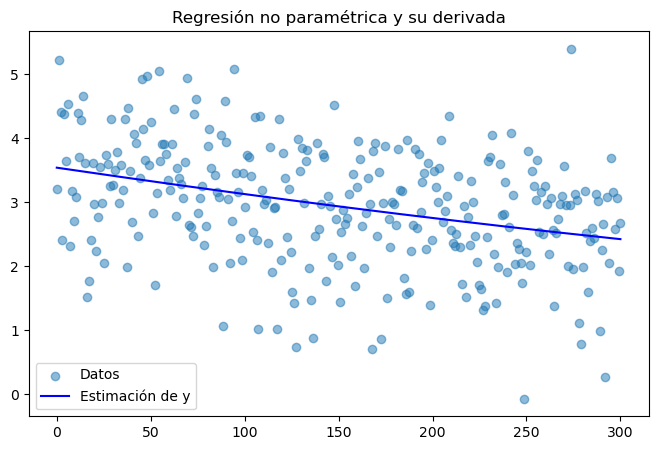

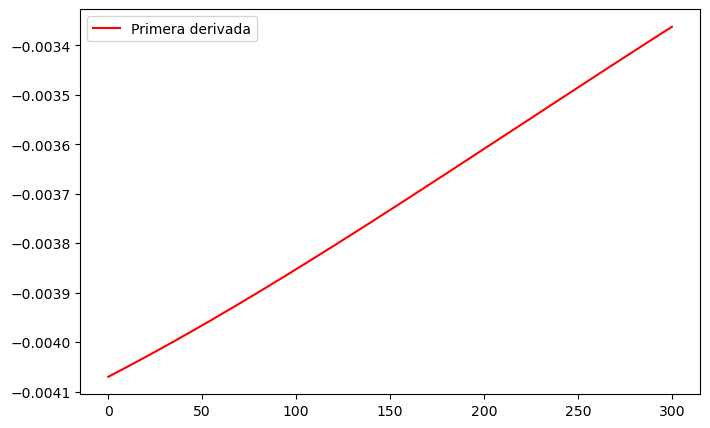

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from statsmodels.nonparametric.kernel_regression import KernelReg


# # Datos simulados
# np.random.seed(123)
# x = np.linspace(0,300, 300)
# y = data_noisy[15299:15599]

# # Ajuste no paramétrico
# kr = KernelReg(y, x, var_type='c')  # 'c' indica que x es continua
# y_pred, dy_dx = kr.fit(x)  # Obtiene la estimación de y y su derivada

# # Gráfico de la estimación y la derivada
# plt.figure(figsize=(8, 5))
# plt.scatter(x, y, label="Datos", alpha=0.5)
# plt.plot(x, y_pred, label="Estimación de y", color="blue") 
# # plt.plot(x, dy_dx, label="Primera derivada", color="red")
# plt.legend()
# plt.title("Regresión no paramétrica y su derivada")
# plt.show()

# plt.figure(figsize=(8, 5))
# plt.plot(x, dy_dx, label="Primera derivada", color="red")
# plt.legend()
# plt.show()

In [ ]:
guardar_estadisticas("KSWIN_modificado", "incremental", "normal",drifts_totales, puntos_detectados, falsas_alarmas, tiempo_total, "estadisticas_pruebas_generales.xlsx")

Numero de falsas alarmas 37
FAR: 0.03903
Drift drift_incremental en el punto {'inicio': 15000, 'fin': 17000, 'detectado': False} no detectado
Drift drift_incremental en el punto {'inicio': 15000, 'fin': 17000, 'detectado': False} no detectado
Drift drift_incremental en el punto {'inicio': 15000, 'fin': 17000, 'detectado': False} no detectado
Drift drift_incremental en el punto {'inicio': 15000, 'fin': 18000, 'detectado': False} no detectado
Drift drift_incremental en el punto {'inicio': 15000, 'fin': 17000, 'detectado': False} no detectado
Drift drift_incremental en el punto {'inicio': 15000, 'fin': 17000, 'detectado': False} no detectado
Drift drift_incremental en el punto {'inicio': 15000, 'fin': 16000, 'detectado': False} no detectado
Drift drift_incremental en el punto {'inicio': 15000, 'fin': 17000, 'detectado': False} no detectado
Drift drift_incremental en el punto {'inicio': 15000, 'fin': 17000, 'detectado': False} no detectado
Drift drift_incremental en el punto {'inicio': 150

#### Distribucion normal (configuracion 1)

In [ ]:


num_iteracciones = 1000


puntos_detectados = []
falsas_alarmas = []
drifts_totales = []
tiempo_total = 0
 
for i in range(num_iteracciones): 
    
    kswin_modificado = KSWIN_modificado(alpha=0.001, window_start=0, window_size=3000, stat_size=300, confirm_drift=False, configuracion=1, alternative='two-sided', es_continua=True)
    data_noisy, drifts = crear_dataset_incremental_General(seed_aux=24 + i, ruido_std=0.05, distribucion="normal")

    drifts_totales.append(drifts)

    tiempo_inicial = time.time()

    puntos_detectados_aux, falsas_alarmas_aux = realizar_deteccion(data_noisy, drifts,  kswin_modificado, 300, [], True)


    tiempo_total += time.time() - tiempo_inicial

    # plot_data(data_noisy, puntos_detectados_aux, drifts)

    puntos_detectados.extend(puntos_detectados_aux)
    falsas_alarmas.extend(falsas_alarmas_aux)

Drift detectado en el índice 16199
Drift detectado en el índice 15299
Drift detectado en el índice 15899
Drift detectado en el índice 15899
Drift detectado en el índice 15299
Drift detectado en el índice 15599
Drift detectado en el índice 15299
Drift detectado en el índice 15299
Drift detectado en el índice 16499
Drift detectado en el índice 15899
Drift detectado en el índice 15599
Drift detectado en el índice 15299
Drift detectado en el índice 15599
Drift detectado en el índice 15599
Drift detectado en el índice 15299
Drift detectado en el índice 15299
Drift detectado en el índice 15899
Drift detectado en el índice 16499
Drift detectado en el índice 15299
Drift detectado en el índice 15599
Drift detectado en el índice 15299
Drift detectado en el índice 16199
Drift detectado en el índice 15299
Drift detectado en el índice 3599
Drift detectado en el índice 15599
Drift detectado en el índice 15299
Drift detectado en el índice 15599
Drift detectado en el índice 15599
Drift detectado en el

KeyboardInterrupt: 

In [ ]:
guardar_estadisticas("KSWIN_modificado (config original)", "incremental", "normal",drifts_totales, puntos_detectados, falsas_alarmas, tiempo_total, "estadisticas_pruebas_generales.xlsx")

#### Distribucion exponencial (configuracion 2)

In [ ]:


num_iteracciones = 1000


puntos_detectados = []
falsas_alarmas = []
drifts_totales = []
tiempo_total = 0
 
for i in range(num_iteracciones): 
    
    kswin_modificado = KSWIN_modificado(alpha=0.001, window_start=0, window_size=3000, stat_size=300, confirm_drift=False, configuracion=2, alternative='two-sided', es_continua=True)
    data_noisy, drifts = crear_dataset_incremental_General(seed_aux=24 + i, ruido_std=0.05, distribucion="exponential")

    drifts_totales.append(drifts)

    tiempo_inicial = time.time()

    puntos_detectados_aux, falsas_alarmas_aux = realizar_deteccion(data_noisy, drifts,  kswin_modificado, 300, [], True)


    tiempo_total += time.time() - tiempo_inicial

    # plot_data(data_noisy, puntos_detectados_aux, drifts)

    puntos_detectados.extend(puntos_detectados_aux)
    falsas_alarmas.extend(falsas_alarmas_aux)

Drift detectado en el índice 15299
Drift detectado en el índice 15299
Drift detectado en el índice 15299
Drift detectado en el índice 15299
Drift detectado en el índice 15299
Drift detectado en el índice 15299
Drift detectado en el índice 15299


KeyboardInterrupt: 

In [ ]:
guardar_estadisticas("KSWIN_modificado", "incremental", "exponential",drifts_totales, puntos_detectados, falsas_alarmas, tiempo_total, "estadisticas_pruebas_generales.xlsx")

#### Distribucion gamma (configuracion 2)

In [ ]:


num_iteracciones = 1000


puntos_detectados = []
falsas_alarmas = []
drifts_totales = []
tiempo_total = 0
 
for i in range(num_iteracciones): 
    
    kswin_modificado = KSWIN_modificado(alpha=0.001, window_start=0, window_size=3000, stat_size=300, confirm_drift=False, configuracion=2, alternative='two-sided', es_continua=True)
    data_noisy, drifts = crear_dataset_incremental_General(seed_aux=24 + i, ruido_std=0.05, distribucion="gamma")

    drifts_totales.append(drifts)

    tiempo_inicial = time.time()

    puntos_detectados_aux, falsas_alarmas_aux = realizar_deteccion(data_noisy, drifts,  kswin_modificado, 300, [], True)


    tiempo_total += time.time() - tiempo_inicial

    # plot_data(data_noisy, puntos_detectados_aux, drifts)

    puntos_detectados.extend(puntos_detectados_aux)
    falsas_alarmas.extend(falsas_alarmas_aux)

In [ ]:
guardar_estadisticas("KSWIN_modificado", "incremental", "gamma",drifts_totales, puntos_detectados, falsas_alarmas, tiempo_total, "estadisticas_pruebas_generales.xlsx")

#### Distribucion exponencial (configuracion 1)

In [ ]:


num_iteracciones = 1000


puntos_detectados = []
falsas_alarmas = []
drifts_totales = []
tiempo_total = 0
 
for i in range(num_iteracciones): 
    
    kswin_modificado = KSWIN_modificado(alpha=0.001, window_start=0, window_size=3000, stat_size=300, confirm_drift=False, configuracion=1, alternative='two-sided', es_continua=True)
    data_noisy, drifts = crear_dataset_incremental_General(seed_aux=24 + i, ruido_std=0.05, distribucion="exponential")

    drifts_totales.append(drifts)

    tiempo_inicial = time.time()

    puntos_detectados_aux, falsas_alarmas_aux = realizar_deteccion(data_noisy, drifts,  kswin_modificado, 300, [], True)


    tiempo_total += time.time() - tiempo_inicial

    # plot_data(data_noisy, puntos_detectados_aux, drifts)

    puntos_detectados.extend(puntos_detectados_aux)
    falsas_alarmas.extend(falsas_alarmas_aux)

In [ ]:
guardar_estadisticas("KSWIN_modificado (config original)", "incremental", "exponencial",drifts_totales, puntos_detectados, falsas_alarmas, tiempo_total, "estadisticas_pruebas_generales.xlsx")

#### Distribucion gamma (configuracion 1)

In [ ]:

num_iteracciones = 1000


puntos_detectados = []
falsas_alarmas = []
drifts_totales = []
tiempo_total = 0
 
for i in range(num_iteracciones): 
    
    kswin_modificado = KSWIN_modificado(alpha=0.001, window_start=0, window_size=3000, stat_size=300, confirm_drift=False, configuracion=1, alternative='two-sided', es_continua=True)
    data_noisy, drifts = crear_dataset_incremental_General(seed_aux=24 + i, ruido_std=0.05, distribucion="gamma")

    drifts_totales.append(drifts)

    tiempo_inicial = time.time()

    puntos_detectados_aux, falsas_alarmas_aux = realizar_deteccion(data_noisy, drifts,  kswin_modificado, 300, [], True)


    tiempo_total += time.time() - tiempo_inicial

    # plot_data(data_noisy, puntos_detectados_aux, drifts)

    puntos_detectados.extend(puntos_detectados_aux)
    falsas_alarmas.extend(falsas_alarmas_aux)

In [ ]:
guardar_estadisticas("KSWIN_modificado (config original)", "incremental", "gamma",drifts_totales, puntos_detectados, falsas_alarmas, tiempo_total, "estadisticas_pruebas_generales.xlsx")

### Gradual drift

#### Distribucion normal (configuracion 2)

In [ ]:

num_iteracciones = 1000

puntos_detectados = []
falsas_alarmas = []
drifts_totales = []
tiempo_total = 0
 
for i in range(num_iteracciones): 
    
    kswin_modificado = KSWIN_modificado(alpha=0.001, window_start=0, window_size=3000, stat_size=300, confirm_drift=False, configuracion=2, alternative='two-sided', es_continua=True)
    data_noisy, drifts = crear_dataset_gradual_General(seed_aux=25 + i, ruido_std=0.05, distribucion="normal")

    drifts_totales.append(drifts)


    tiempo_inicial = time.time()

    puntos_detectados_aux, falsas_alarmas_aux = realizar_deteccion(data_noisy, drifts,  kswin_modificado, 300, [], True)

    tiempo_total += time.time() - tiempo_inicial

    # plot_data(data_noisy, puntos_detectados_aux, drifts)


    puntos_detectados.extend(puntos_detectados_aux)
    falsas_alarmas.extend(falsas_alarmas_aux)

Drift detectado en el índice 15599
Drift detectado en el índice 16499
Drift detectado en el índice 15899
Drift detectado en el índice 15599
Drift detectado en el índice 15899
Drift detectado en el índice 15599
Drift detectado en el índice 15599
Drift detectado en el índice 16799
Drift detectado en el índice 17099
Drift detectado en el índice 15899
Drift detectado en el índice 15899
Drift detectado en el índice 16199
Drift detectado en el índice 15899
Drift detectado en el índice 15599
Drift detectado en el índice 10799
Drift detectado en el índice 15899
Drift detectado en el índice 16199
Drift detectado en el índice 17399
Drift detectado en el índice 16799
Drift detectado en el índice 15599
Drift detectado en el índice 15899
Drift detectado en el índice 15599
Drift detectado en el índice 16499
Drift detectado en el índice 15899
Drift detectado en el índice 15899
Drift detectado en el índice 16199
Drift detectado en el índice 15599
Drift detectado en el índice 15599
Drift detectado en e

In [ ]:
guardar_estadisticas("KSWIN_modificado", "gradual", "normal",drifts_totales, puntos_detectados, falsas_alarmas, tiempo_total, "estadisticas_pruebas_generales.xlsx")

Numero de falsas alarmas 37
FAR: 0.03907
Drift drift_incremental en el punto {'inicio': 15000, 'fin': 17000, 'detectado': False} no detectado
Drift drift_incremental en el punto {'inicio': 15000, 'fin': 17000, 'detectado': False} no detectado
Drift drift_incremental en el punto {'inicio': 15000, 'fin': 17000, 'detectado': False} no detectado
Drift drift_incremental en el punto {'inicio': 15000, 'fin': 17000, 'detectado': False} no detectado
Drift drift_incremental en el punto {'inicio': 15000, 'fin': 17000, 'detectado': False} no detectado
Drift drift_incremental en el punto {'inicio': 15000, 'fin': 17000, 'detectado': False} no detectado
Drift drift_incremental en el punto {'inicio': 15000, 'fin': 17000, 'detectado': False} no detectado
Drift drift_incremental en el punto {'inicio': 15000, 'fin': 17000, 'detectado': False} no detectado
Drift drift_incremental en el punto {'inicio': 15000, 'fin': 17000, 'detectado': False} no detectado
Drift drift_incremental en el punto {'inicio': 150

#### Distribucion normal (configuracion 1)

In [ ]:

num_iteracciones = 1000

puntos_detectados = []
falsas_alarmas = []
drifts_totales = []
tiempo_total = 0
 
for i in range(num_iteracciones): 
    
    kswin_modificado = KSWIN_modificado(alpha=0.001, window_start=0, window_size=3000, stat_size=300, confirm_drift=False, configuracion=1, alternative='two-sided', es_continua=True)
    data_noisy, drifts = crear_dataset_gradual_General(seed_aux=25 + i, ruido_std=0.05, distribucion="normal")

    drifts_totales.append(drifts)


    tiempo_inicial = time.time()

    puntos_detectados_aux, falsas_alarmas_aux = realizar_deteccion(data_noisy, drifts,  kswin_modificado, 300, [], True)

    tiempo_total += time.time() - tiempo_inicial

    # plot_data(data_noisy, puntos_detectados_aux, drifts)


    puntos_detectados.extend(puntos_detectados_aux)
    falsas_alarmas.extend(falsas_alarmas_aux)

In [ ]:
guardar_estadisticas("KSWIN_modificado (config original)", "gradual", "normal",drifts_totales, puntos_detectados, falsas_alarmas, tiempo_total, "estadisticas_pruebas_generales.xlsx")

#### Distribucion exponencial(configuracion 2)

In [ ]:

num_iteracciones = 1000

puntos_detectados = []
falsas_alarmas = []
drifts_totales = []
tiempo_total = 0
 
for i in range(num_iteracciones): 
    
    kswin_modificado = KSWIN_modificado(alpha=0.001, window_start=0, window_size=3000, stat_size=300, confirm_drift=False, configuracion=2, alternative='two-sided', es_continua=True)
    data_noisy, drifts = crear_dataset_gradual_General(seed_aux=25 + i, ruido_std=0.05, distribucion="exponential")

    drifts_totales.append(drifts)


    tiempo_inicial = time.time()

    puntos_detectados_aux, falsas_alarmas_aux = realizar_deteccion(data_noisy, drifts,  kswin_modificado, 300, [], True)

    tiempo_total += time.time() - tiempo_inicial

    # plot_data(data_noisy, puntos_detectados_aux, drifts)


    puntos_detectados.extend(puntos_detectados_aux)
    falsas_alarmas.extend(falsas_alarmas_aux)

In [ ]:
guardar_estadisticas("KSWIN_modificado", "gradual", "exponential",drifts_totales, puntos_detectados, falsas_alarmas, tiempo_total, "estadisticas_pruebas_generales.xlsx")

#### Distribucion gamma (configuracion 2)

In [ ]:


num_iteracciones = 1000

puntos_detectados = []
falsas_alarmas = []
drifts_totales = []
tiempo_total = 0
 
for i in range(num_iteracciones): 
    
    kswin_modificado = KSWIN_modificado(alpha=0.001, window_start=0, window_size=3000, stat_size=300, confirm_drift=False, configuracion=2, alternative='two-sided', es_continua=True)
    data_noisy, drifts = crear_dataset_gradual_General(seed_aux=25 + i, ruido_std=0.05, distribucion="gamma")

    drifts_totales.append(drifts)


    tiempo_inicial = time.time()

    puntos_detectados_aux, falsas_alarmas_aux = realizar_deteccion(data_noisy, drifts,  kswin_modificado, 300, [], True)

    tiempo_total += time.time() - tiempo_inicial

    # plot_data(data_noisy, puntos_detectados_aux, drifts)


    puntos_detectados.extend(puntos_detectados_aux)
    falsas_alarmas.extend(falsas_alarmas_aux)

In [ ]:
guardar_estadisticas("KSWIN_modificado", "gradual", "gamma",drifts_totales, puntos_detectados, falsas_alarmas, tiempo_total, "estadisticas_pruebas_generales.xlsx")

#### Distribucion exponencial (configuracion 1)

In [ ]:


num_iteracciones = 1000

puntos_detectados = []
falsas_alarmas = []
drifts_totales = []
tiempo_total = 0
 
for i in range(num_iteracciones): 
    
    kswin_modificado = KSWIN_modificado(alpha=0.001, window_start=0, window_size=3000, stat_size=300, confirm_drift=False, configuracion=1, alternative='two-sided', es_continua=True)
    data_noisy, drifts = crear_dataset_gradual_General(seed_aux=25 + i, ruido_std=0.05, distribucion="exponential")

    drifts_totales.append(drifts)


    tiempo_inicial = time.time()

    puntos_detectados_aux, falsas_alarmas_aux = realizar_deteccion(data_noisy, drifts,  kswin_modificado, 300, [], True)

    tiempo_total += time.time() - tiempo_inicial

    # plot_data(data_noisy, puntos_detectados_aux, drifts)


    puntos_detectados.extend(puntos_detectados_aux)
    falsas_alarmas.extend(falsas_alarmas_aux)

In [ ]:
guardar_estadisticas("KSWIN_modificado (config original)", "gradual", "exponencial",drifts_totales, puntos_detectados, falsas_alarmas, tiempo_total, "estadisticas_pruebas_generales.xlsx")

#### Distribucion gamma (configuracion 1)

In [ ]:


num_iteracciones = 1000

puntos_detectados = []
falsas_alarmas = []
drifts_totales = []
tiempo_total = 0
 
for i in range(num_iteracciones): 
    
    kswin_modificado = KSWIN_modificado(alpha=0.001, window_start=0, window_size=3000, stat_size=300, confirm_drift=False, configuracion=1, alternative='two-sided', es_continua=True)
    data_noisy, drifts = crear_dataset_gradual_General(seed_aux=25 + i, ruido_std=0.05, distribucion="gamma")

    drifts_totales.append(drifts)


    tiempo_inicial = time.time()

    puntos_detectados_aux, falsas_alarmas_aux = realizar_deteccion(data_noisy, drifts,  kswin_modificado, 300, [], True)

    tiempo_total += time.time() - tiempo_inicial

    # plot_data(data_noisy, puntos_detectados_aux, drifts)


    puntos_detectados.extend(puntos_detectados_aux)
    falsas_alarmas.extend(falsas_alarmas_aux)

In [ ]:
guardar_estadisticas("KSWIN_modificado (config original)", "gradual", "gamma",drifts_totales, puntos_detectados, falsas_alarmas, tiempo_total, "estadisticas_pruebas_generales.xlsx")